# **Temporal Difference**
----

## Goals of this notebook:

1. Execute a simple experiment to make sure that my hand-made Temporal Difference-based algorithms (for both prediction and control) are mistake proof.
---
## Library imports

#### 1. RL libraries:

In [1]:
import environments
from agents.agents import TDLambdaPredictor, WatkinsLambda, Sarsa, QLearning, SarsaLambda

#### 2. Data aggregation and matrix operation libraries:

In [2]:
import numpy as np
import pandas as pd

#### 3. Plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

#### 4. Statistical analysis tools:

In [4]:
from statsmodels.tsa.stattools import adfuller

----

## Common plotting utilities:

#### Average reward time series:

In [5]:
def plot_reward_time_series(X,Y, far=True):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    far: bool. If False the plots zooms in.
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically
    max_domain = X[-1]
    multiplier = len(str(max_domain)) - 2
    step = int(str(max_domain)[0]) * 10**multiplier
    domain = np.arange(X[0], max_domain + step, step)
    
    if far:
        ylim = (-1, 1)
        yticks= np.round(np.arange(-1,1.05,0.05), 2)
    else:
        max_value = max(0, max(Y))
        ylim = (min(Y), max_value)
        yticks = np.round(np.arange(min(Y)-0.1, max_value+0.1, 0.01), 2)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (X[0], max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': ylim,
                  'yticks': yticks,
                  'yticklabels': yticks,
                  'title': 'Average reward over last {0:,.0f} episodes'.format(X[0])
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter(useMathText=True)
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    ax.plot(X,Y)
    
    return ax

#### Density plot:

In [6]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average rewards
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.2f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'\
            .format(data.mean(),
                    data.std(),
                    data.index.values[0],
                    len(data))
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20, kde=True)
    
    #Delimiting tails:
    ax_hist.axvline(x=np.percentile(data,[2.5]), label='2.5th percentile', c='r')
    ax_hist.axvline(x=np.percentile(data,[97.5]), label='97.5th percentile', c='r')
    ax_hist.legend()
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [7]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, it must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [8]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must have n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    #I only plot those states wherein there is risk of going bust after hitting once more and, for the sake of symmetry,
    #I manually modify those non-existing usable-ace-related states:
    table[:8,:,1] = 1
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

---

## Statistical functions:

I use an **alpha value of 1%** for any statistical test executed in this project

In [9]:
CONFIDENCE_STRING_FORMAT = '1%'
CONFIDENCE = 0.01

In [10]:
def dickey_fuller(time_series, confidence=CONFIDENCE):
    fuller_results = adfuller(time_series)
    if fuller_results[1] <= confidence:
        return 'Null hypothesis can be rejected. The series is stationary.'
    else:
        return 'Null hypothesis cannot be rejected. The series is not stationary'

----

## Experiment Definition:

The method has changed with respect to Montecarlo Notebook. It is necessary to make a one-step look-ahead when updating the agent's table, so that the $S_{t+1}$ state representation is an extra parameter for the "evaluate_state" method.

In [11]:
def run_experiment_one_step(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    env: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

For Sarsa-related experimentation, the method needs a subsequent modification: those algorithms additionally take into account the action at the next time-step (if that exists):

In [12]:
def run_experiment_sarsa(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    env: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        next_action = None
        while not terminal:
            if next_action:
                action = next_action
            else:
                action = agent.follow_policy(state)
                
            next_state, reward, terminal, _ = env.step(action)
            if not terminal:
                next_action = agent.follow_policy(next_state)
            else:
                next_action = None
                
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state, next_action)   
            
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

---

## Agent Deployments

### 1. TD(0) Prediction:

Unlike Montecarlo prediction, the V-function is updated at every time step (online). The estimated value at a given state $s$ following a policy $\pi$ is:

$$V_\pi(s) = \mathbb{E}_\pi[G_t |S_t=s] = \mathbb{E}_\pi[R_{t+1} + \gamma G_{t+1} | S_t=s] = \mathbb{E}_\pi[R_{t+1} + \gamma V_\pi(S_{t+1}) | S_t=s]$$

So the estimated value of $s_t$ takes into account the estimation of the following visited state $s_{t+1}$ to enable updates on a per time-step basis.

The algorithm implementation is as follows:

<img src='interfaces/web/static/img/TD_Prediction.png'>

I swiftly proceed as presented in the Montecarlo Notebook:

In [15]:
#create an environment instance:
env = environments.make('hitstand')

In [14]:
# subclass TDLambdaPredictor to state a policy
class Deterministic(TDLambdaPredictor):
    
    def follow_policy(self, observation, *args):
        #If your points add up to a value greather than 19, stand; otherwise, hit:
        if observation[0] > 19:
            return 0
        else:
            return 1

In [15]:
#create an agent:
td_predictor = Deterministic(env)

In [16]:
td_predictor.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'max_episodes': None,
 '_lambda': 1,
 'traces': 'accumulating'}

In [17]:
#modify some parameters to adjust values to a strict TD(0):
td_predictor.set_hyperparams(_lambda=0)
# Sutton and Barton consider that fix learning rates are better for temporal difference
#I'll try to delve into it in a later notebook
td_predictor.set_hyperparams(learning_rate=0.01)
td_predictor.hyperparams

{'discount_rate': 1,
 'learning_rate': 0.01,
 'max_episodes': None,
 '_lambda': 0,
 'traces': 'accumulating'}

In [18]:
EPISODES = 100_000
SHOW_EVERY = 10_000
SAVE_EVERY =  None
COLLECT_EVERY = 50
results = run_experiment_one_step(env, td_predictor, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 10000:
Jack:
	-Cards: ['AH', '2C']
	-Value : 13
Dealer:
	-Cards: ['10S']
	-Value : 10
Jack decides to: HIT
	-Cards: ['AH', '2C', '8D']
	-Value : 21
Dealer:
	-Cards: ['10S', 'QH']
	-Value : 20
JACK BEATS THE HOUSE
Episode 20000:
Jack:
	-Cards: ['JH', '8D']
	-Value : 18
Dealer:
	-Cards: ['KH']
	-Value : 10
Jack decides to: HIT
	-Cards: ['JH', '8D', 'AS']
	-Value : 19
Jack decides to: HIT
	-Cards: ['JH', '8D', 'AS', 'JC']
	-Value : 29
Dealer:
	-Cards: ['KH']
	-Value : 10
THE HOUSE BEATS JACK
Episode 30000:
Jack:
	-Cards: ['AC', '4S']
	-Value : 15
Dealer:
	-Cards: ['4D']
	-Value : 4
Jack decides to: HIT
	-Cards: ['AC', '4S', 'KC']
	-Value : 15
Jack decides to: HIT
	-Cards: ['AC', '4S', 'KC', 'KS']
	-Value : 25
Dealer:
	-Cards: ['4D']
	-Value : 4
THE HOUSE BEATS JACK
Episode 40000:
Jack:
	-Cards: ['AS', '7D']
	-Value : 18
Dealer:
	-Cards: ['9C']
	-Value : 9
Jack decides to: HIT
	-Cards: ['AS', '7D', '10D']
	-Value : 18
Jack decides to: HIT
	-Cards: ['AS', '7D', '10D', '9D']
	-Value 

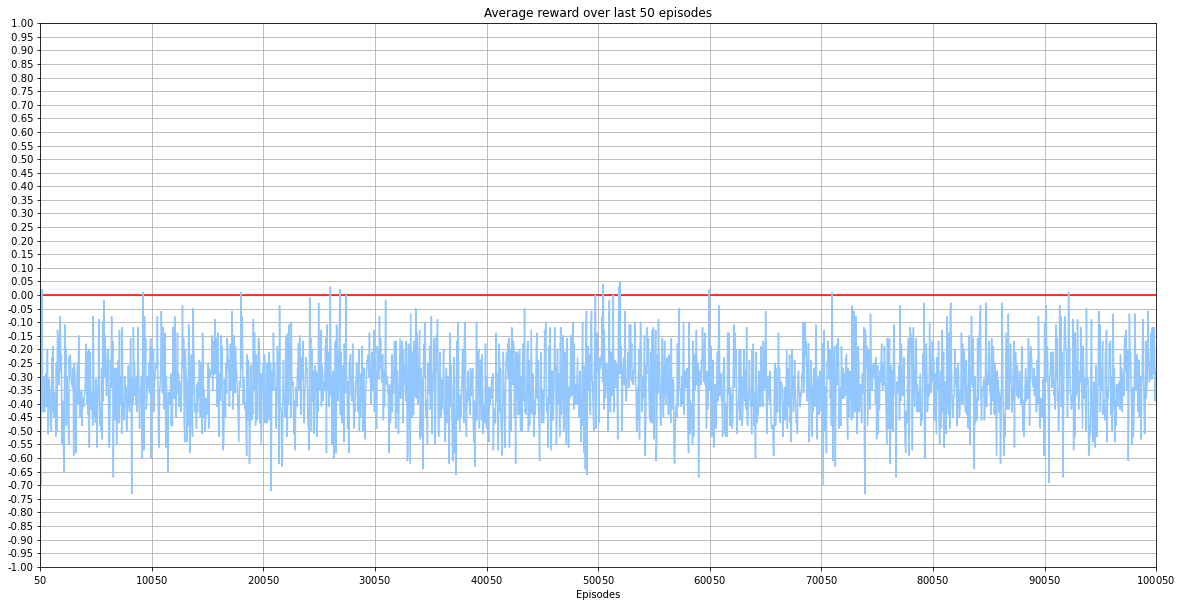

In [19]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

In [20]:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    2000.000000
mean       -0.331660
std         0.131235
min        -0.730000
25%        -0.420000
50%        -0.330000
75%        -0.250000
max         0.050000
dtype: float64

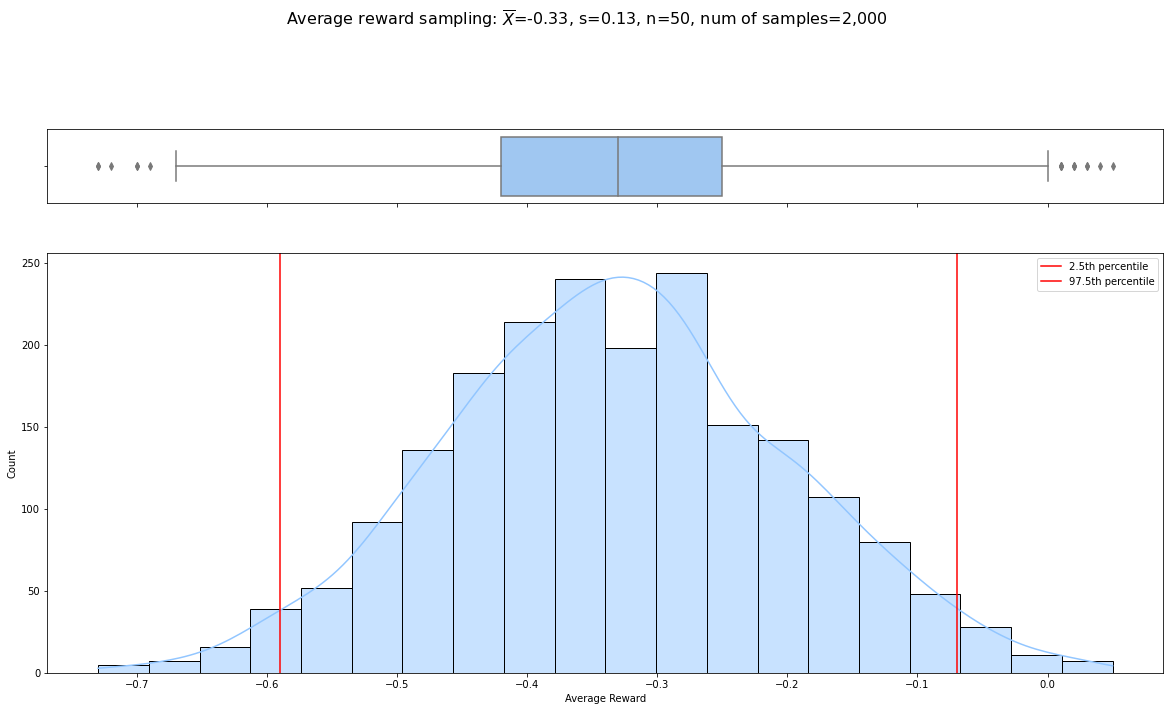

In [21]:
plot_density(runs);

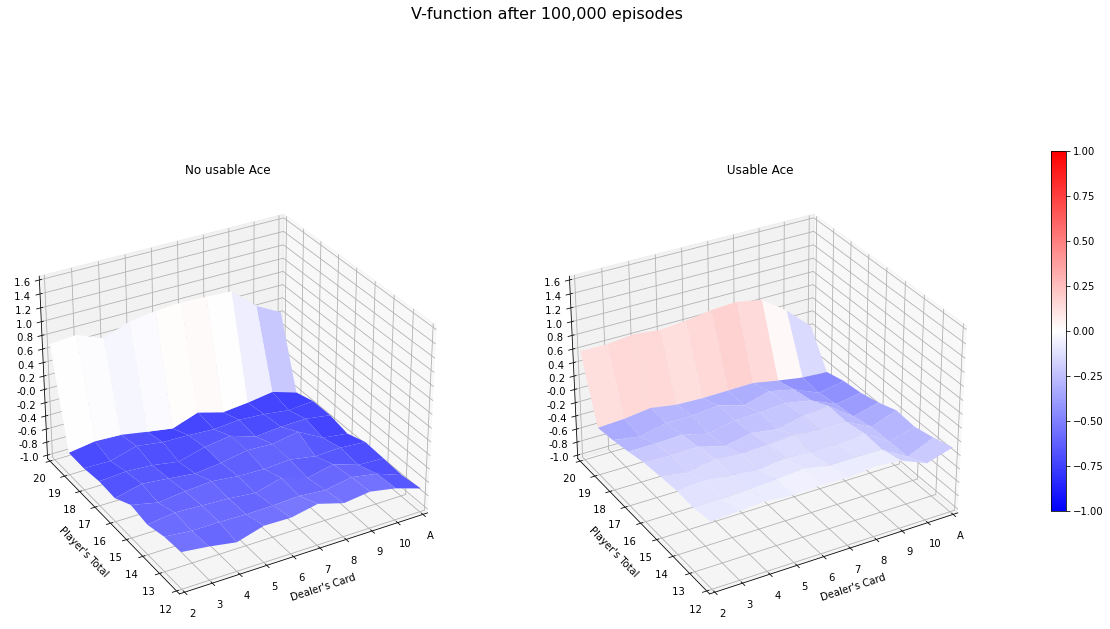

In [22]:
plot_v_func(td_predictor.table, 'V-function after {:,.0f} episodes'.format(EPISODES));

### 2. Sarsa:

It additionally requires the next action taken at the next state to update the table. If the $Q(S_{t+1}, A_{t+1})$ is terminal, its value is zero.

The algorithm is as follows:
<img src="interfaces/web/static/img/Sarsa.png">

In [13]:
class SarsaAgent(Sarsa):
    
    def follow_policy(self, observation, *args):
        #Epsilon greedy:
        table_look_up = tuple(self.table_look_up(observation))
        max_action = np.argmax(self.table[table_look_up][:])
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)

In [16]:
sarsa_agent = SarsaAgent(env)

In [17]:
sarsa_agent.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'max_episodes': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 'ucb_c': 1}

In [18]:
# I arbitrarily tweak the parameters
sarsa_agent.set_hyperparams(learning_rate=0.001)
sarsa_agent.set_hyperparams(epsilon_min=0.1)
sarsa_agent.hyperparams

{'discount_rate': 1,
 'learning_rate': 0.001,
 'max_episodes': None,
 'epsilon_start': 1,
 'epsilon_min': 0.1,
 'epsilon_decay': 0.995,
 'ucb_c': 1}

In [19]:
EPISODES = 200_000
SHOW_EVERY = 100_000
SAVE_EVERY =  None
COLLECT_EVERY = 5_000
results = run_experiment_sarsa(env, sarsa_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['8C', '3H']
	-Value : 11
Dealer:
	-Cards: ['KS']
	-Value : 10
Jack decides to: HIT
	-Cards: ['8C', '3H', 'KH']
	-Value : 21
Dealer:
	-Cards: ['KS', 'QC']
	-Value : 20
JACK BEATS THE HOUSE
Episode 200000:
Jack:
	-Cards: ['4H', '8C']
	-Value : 12
Dealer:
	-Cards: ['5D']
	-Value : 5
Jack decides to: STAND
	-Cards: ['4H', '8C']
	-Value : 12
Dealer:
	-Cards: ['5D', '6D', '7H']
	-Value : 18
THE HOUSE BEATS JACK


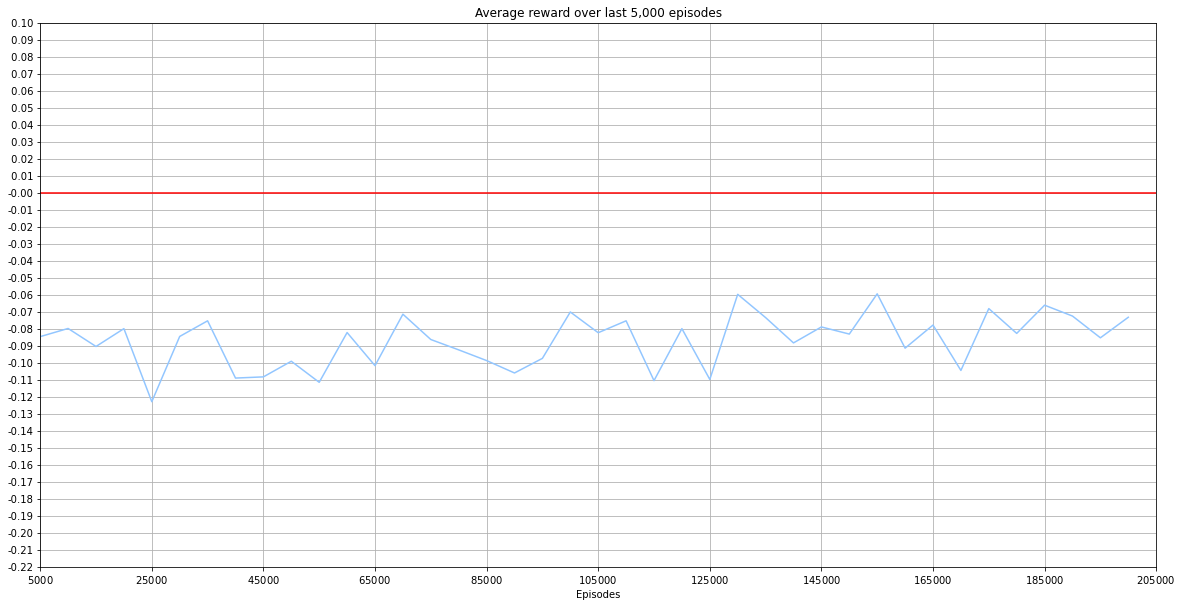

In [20]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results, far=False);

In [21]:
sarsa_agent.num_executed_episodes

190484

In [29]:
results[0], results[19], results[-1]

(-0.1126, -0.0805, -0.0798)

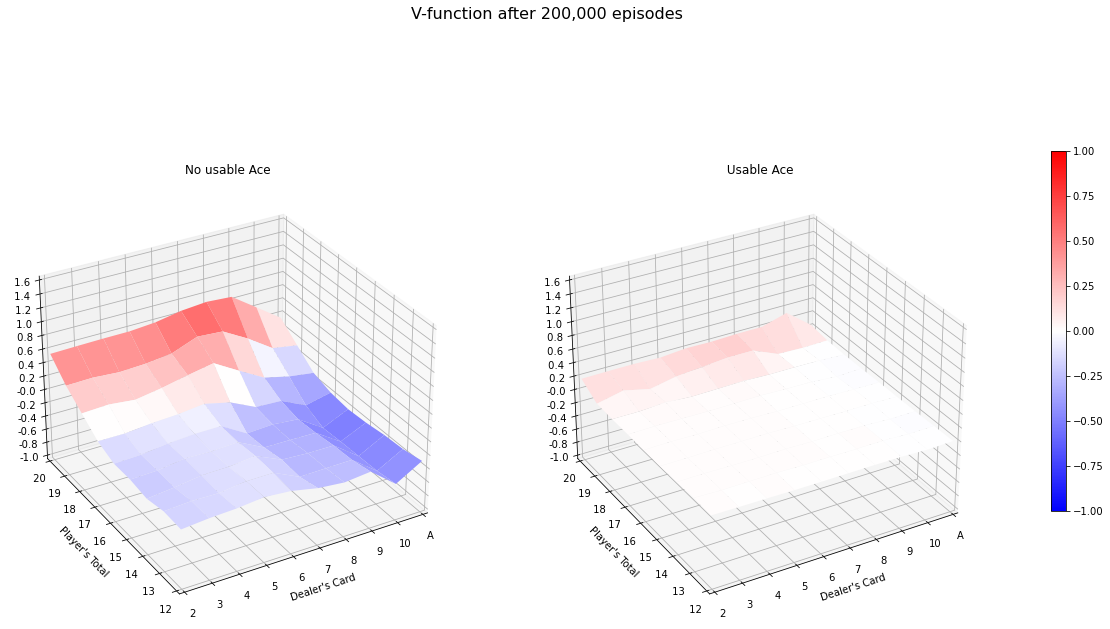

In [22]:
plot_v_func(np.amax(sarsa_agent.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

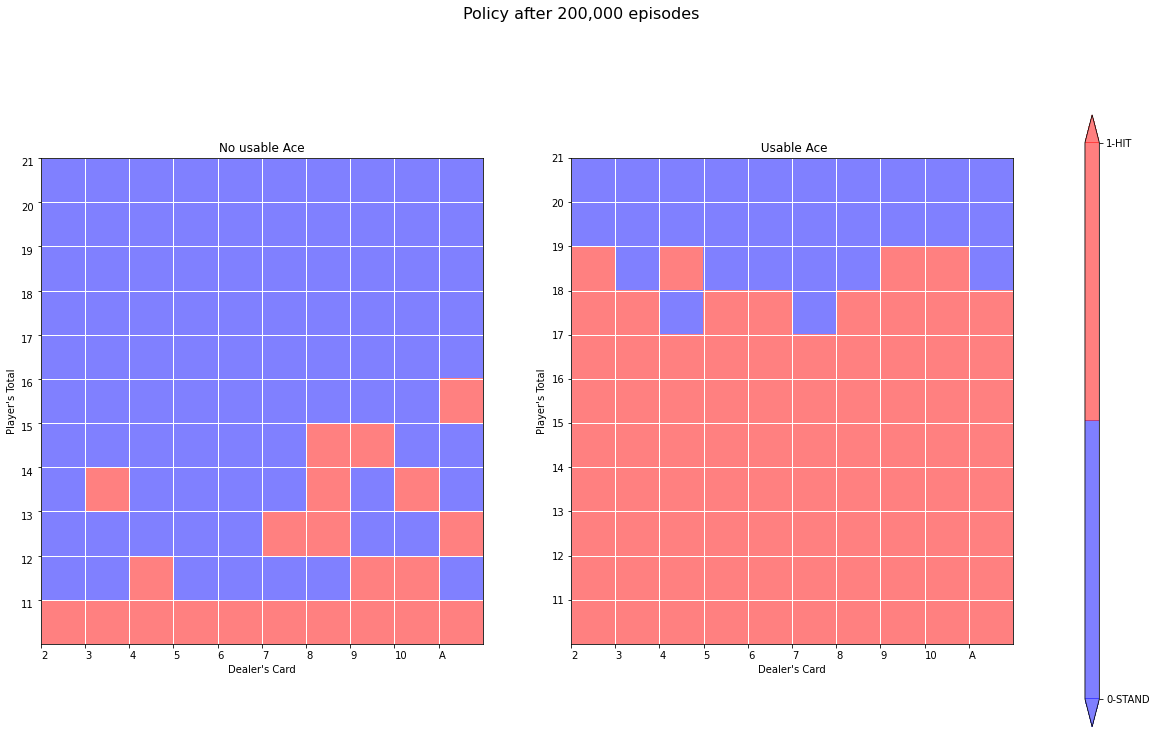

In [23]:
policy_table = np.argmax(sarsa_agent.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));

Learning looks quite weak at first glance.

### 3. Q-Learning

Instead of using the next action taken at the next state, it computes the best action at the next state (greediness).

The algorithm is as follows:

<img src="interfaces/web/static/img/Q_Learning.png">

In [32]:
class QLearner(QLearning):
    
    def follow_policy(self, observation, *args):
        #Epsilon greedy:
        table_look_up = tuple(self.table_look_up(observation))
        max_action = np.argmax(self.table[table_look_up][:])
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)

In [33]:
qlearner = QLearner(env)

In [34]:
qlearner.set_hyperparams(learning_rate=0.001)
qlearner.hyperparams

{'discount_rate': 1,
 'learning_rate': 0.001,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995}

In [35]:
results = run_experiment_one_step(env, qlearner, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['QH', 'JH']
	-Value : 20
Dealer:
	-Cards: ['KS']
	-Value : 10
Jack decides to: STAND
	-Cards: ['QH', 'JH']
	-Value : 20
Dealer:
	-Cards: ['KS', '3S', '5S']
	-Value : 18
JACK BEATS THE HOUSE
Episode 200000:
Jack:
	-Cards: ['2H', 'QH']
	-Value : 12
Dealer:
	-Cards: ['JC']
	-Value : 10
Jack decides to: HIT
	-Cards: ['2H', 'QH', '2H']
	-Value : 14
Jack decides to: HIT
	-Cards: ['2H', 'QH', '2H', '8C']
	-Value : 22
Dealer:
	-Cards: ['JC']
	-Value : 10
THE HOUSE BEATS JACK


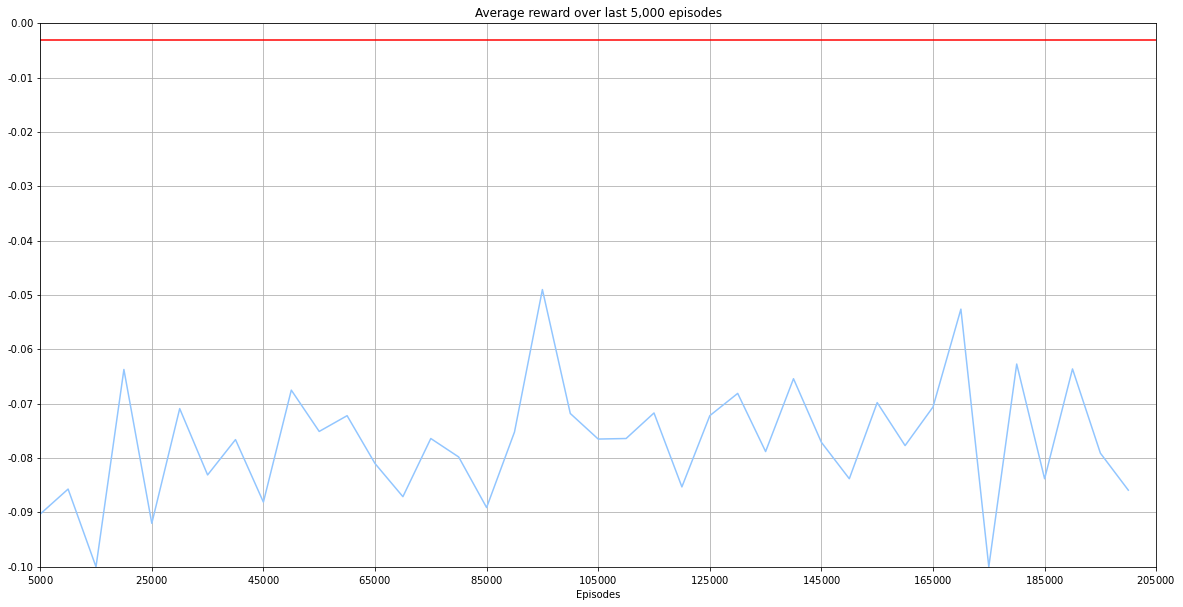

In [36]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results, far=False);

Learning also looks weak. However, do not forget that this effort is just an introduction to the whole bunch of implemented algorithms

In [37]:
results[0], results[19], results[-1]

(-0.0873, -0.0688, -0.0829)

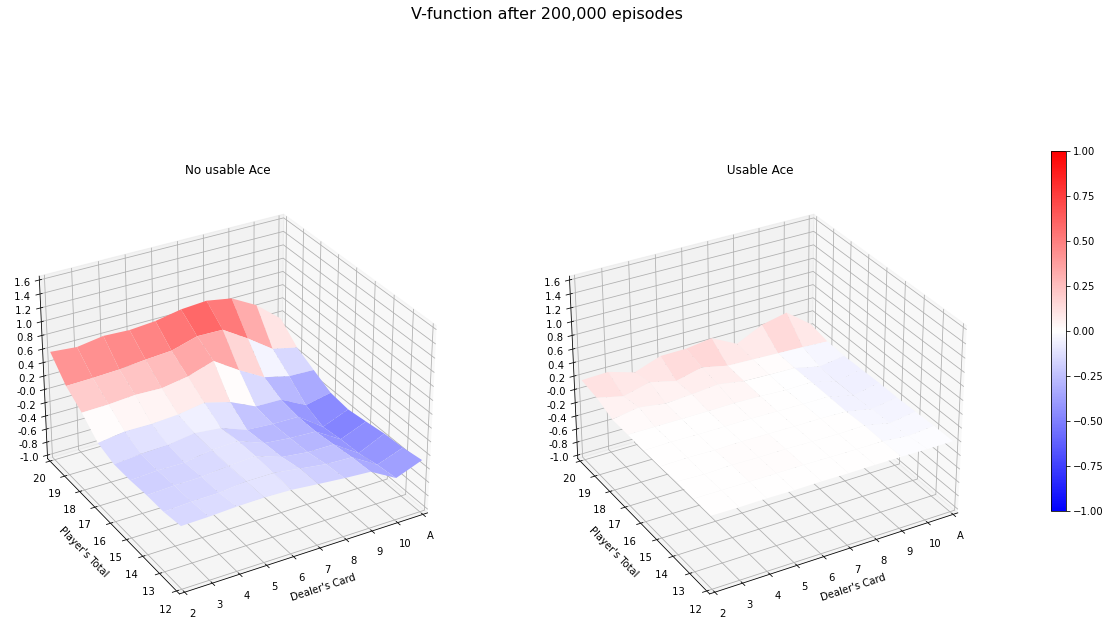

In [38]:
plot_v_func(np.amax(qlearner.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

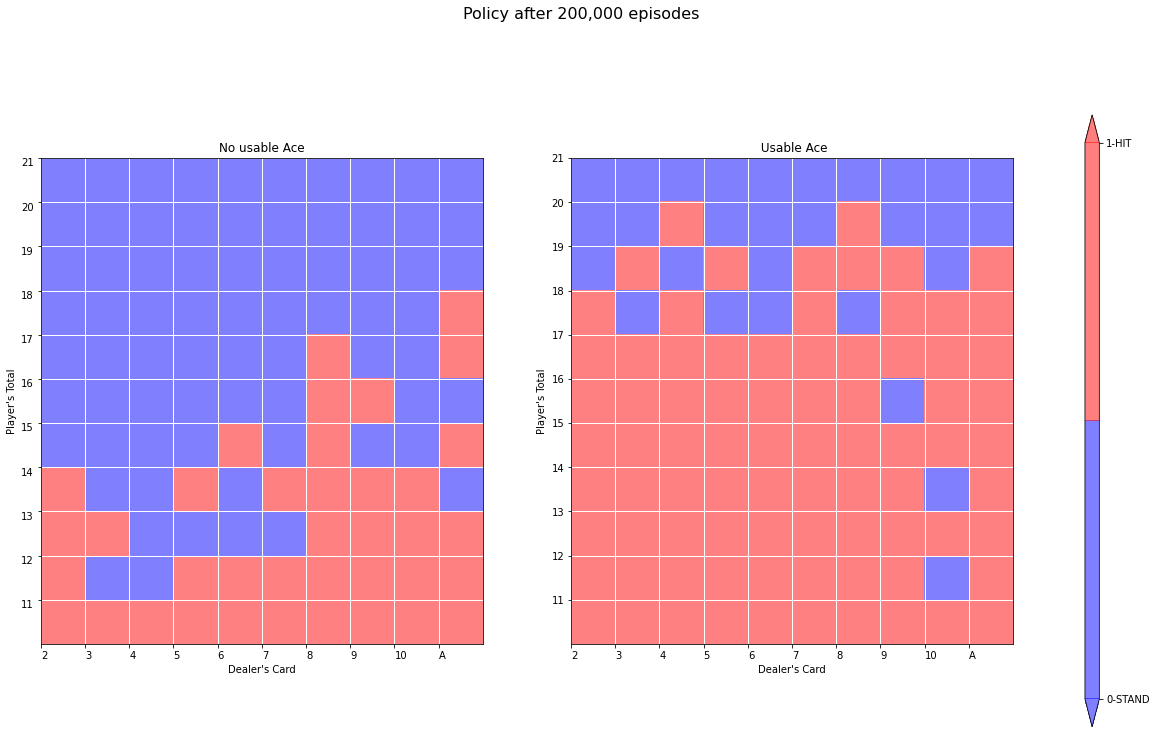

In [39]:
policy_table = np.argmax(qlearner.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));

### 4. Sarsa($\lambda$)

This algorithm uses eligibility traces, which is a way to reconcile both the Montecarlo and TD(0) approaches: whereas the former observes the whole reward sequence up to the end of the episode (long-sighted), the latter only performs a one-step look-ahead (short-sighted). Eligibility traces allow considering the n-step estimations inbetween by calculating a $\lambda$-weighted average based on how frequent a state-action pair have been visited during an episode.

There are three ways to calculate traces (accumulating, replacing and Dutch) and I have hyperparameterized all of them.

The algorithm is as follows:

<img src="interfaces/web/static/img/Sarsa_Lambda.png">

In [40]:
class SarsaLambdaAgent(SarsaLambda):
    
    def follow_policy(self, observation, *args):
        #Epsilon greedy:
        table_look_up = tuple(self.table_look_up(observation))
        max_action = np.argmax(self.table[table_look_up][:])
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)

In [41]:
sarsa_lambda = SarsaLambdaAgent(env)

In [42]:
# I set an arbitrary lambda
sarsa_lambda.set_hyperparams(_lambda=0.95)
sarsa_lambda.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 '_lambda': 0.95,
 'traces': 'accumulating'}

In [43]:
EPISODES = 200_000
SHOW_EVERY = 100_000
SAVE_EVERY =  None
COLLECT_EVERY = 5_000
results = run_experiment_sarsa(env, sarsa_lambda, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['5H', 'JS']
	-Value : 15
Dealer:
	-Cards: ['KD']
	-Value : 10
Jack decides to: STAND
	-Cards: ['5H', 'JS']
	-Value : 15
Dealer:
	-Cards: ['KD', '7D']
	-Value : 17
THE HOUSE BEATS JACK
Episode 200000:
Jack:
	-Cards: ['3C', 'KC']
	-Value : 13
Dealer:
	-Cards: ['QS']
	-Value : 10
Jack decides to: STAND
	-Cards: ['3C', 'KC']
	-Value : 13
Dealer:
	-Cards: ['QS', '9H']
	-Value : 19
THE HOUSE BEATS JACK


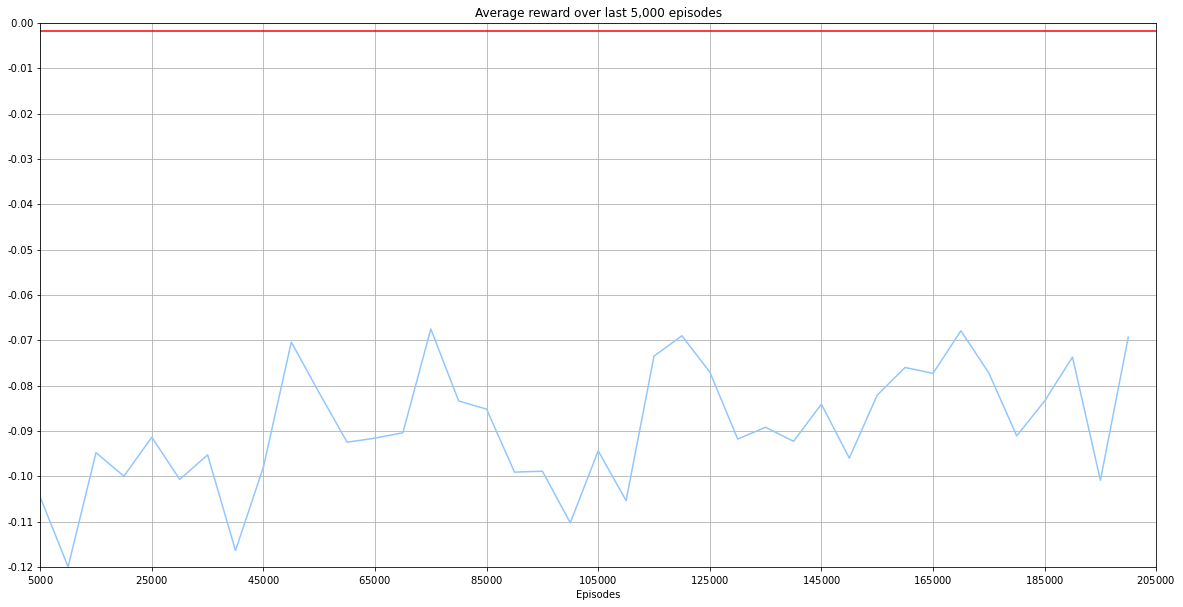

In [44]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results, far=False);

In [45]:
results[0], results[19], results[-1]

(-0.1028, -0.1085, -0.0675)

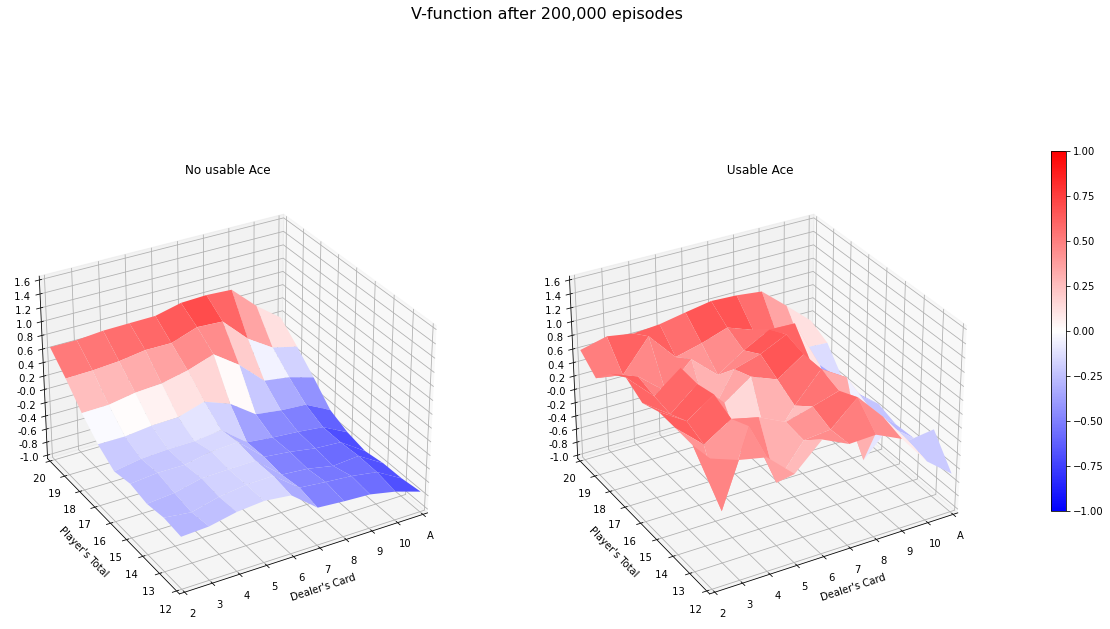

In [46]:
plot_v_func(np.amax(sarsa_lambda.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

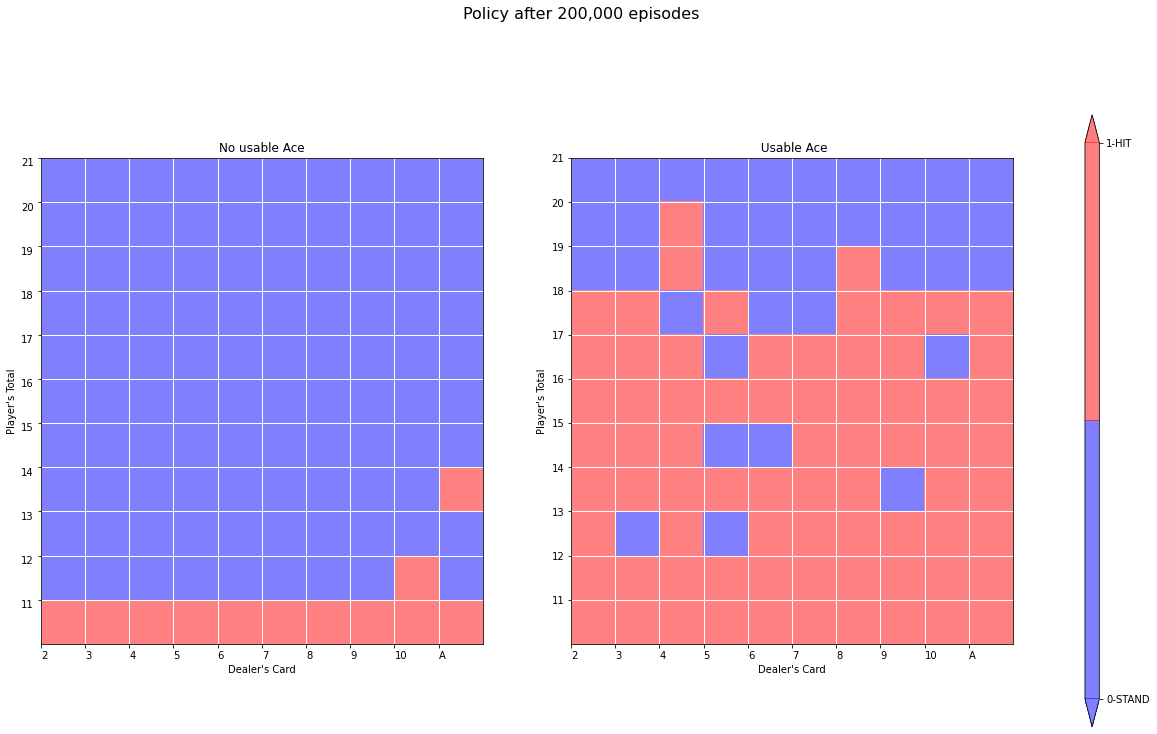

In [47]:
policy_table = np.argmax(sarsa_lambda.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));

### 4. Watkins' Q($\lambda$)

It is Q-Learning evolution that allows for eligibility traces.

There are three ways to calculate traces (accumulating, replacing and Dutch) and I have hyperparameterized all of them.

The algorithm is as follows:

<img src="interfaces/web/static/img/Watkins_Q.png">

In [48]:
class WatkinsAgent(WatkinsLambda):
    
    def follow_policy(self, observation, *args):
        #Epsilon greedy:
        table_look_up = tuple(self.table_look_up(observation))
        max_action = np.argmax(self.table[table_look_up][:])
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)

In [49]:
watkins = WatkinsAgent(env)

In [50]:
watkins.set_hyperparams(_lambda=0.95)
watkins.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 '_lambda': 0.95,
 'traces': 'accumulating'}

In [51]:
EPISODES = 200_000
SHOW_EVERY = 100_000
SAVE_EVERY =  None
COLLECT_EVERY = 5_000
#I use the run_experiment_sarsa method. Although it is Q-learning-based,
#it is necessary to consider the next action to check whether or not eligibility traces should be cut.
results = run_experiment_sarsa(env, watkins, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['KC', '9C']
	-Value : 19
Dealer:
	-Cards: ['2S']
	-Value : 2
Jack decides to: STAND
	-Cards: ['KC', '9C']
	-Value : 19
Dealer:
	-Cards: ['2S', 'QC', '7D']
	-Value : 19
DRAW
Episode 200000:
Jack:
	-Cards: ['QS', '2S']
	-Value : 12
Dealer:
	-Cards: ['2H']
	-Value : 2
Jack decides to: STAND
	-Cards: ['QS', '2S']
	-Value : 12
Dealer:
	-Cards: ['2H', '10H', '3S', 'JH']
	-Value : 25
JACK BEATS THE HOUSE


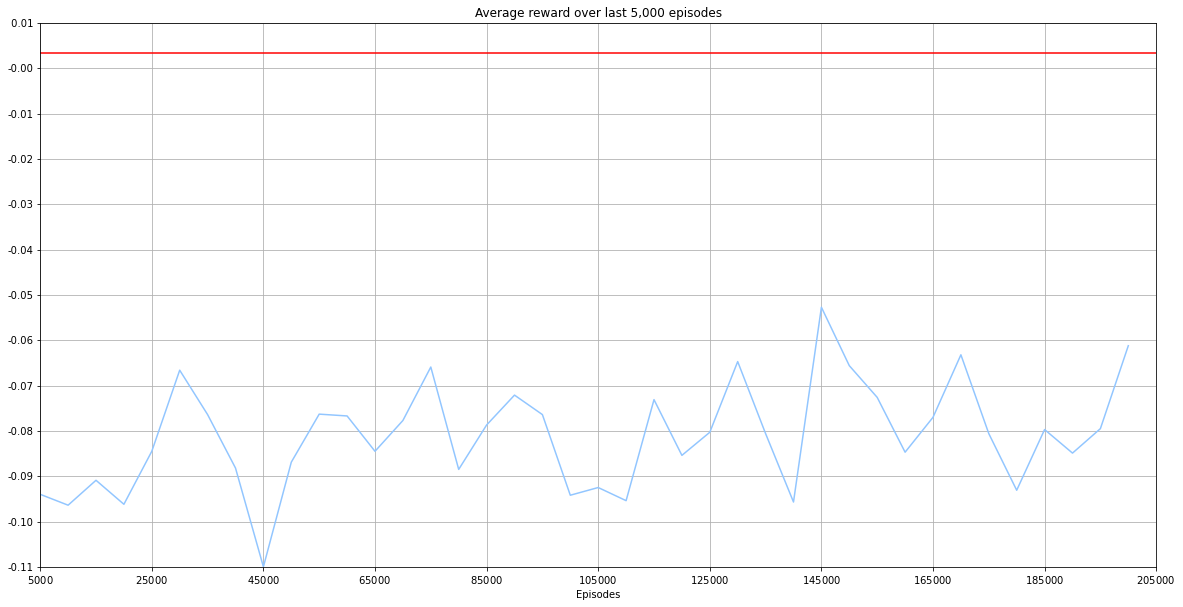

In [52]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results, far=False);

In [53]:
results[0], results[19], results[-1]

(-0.0975, -0.0977, -0.0647)

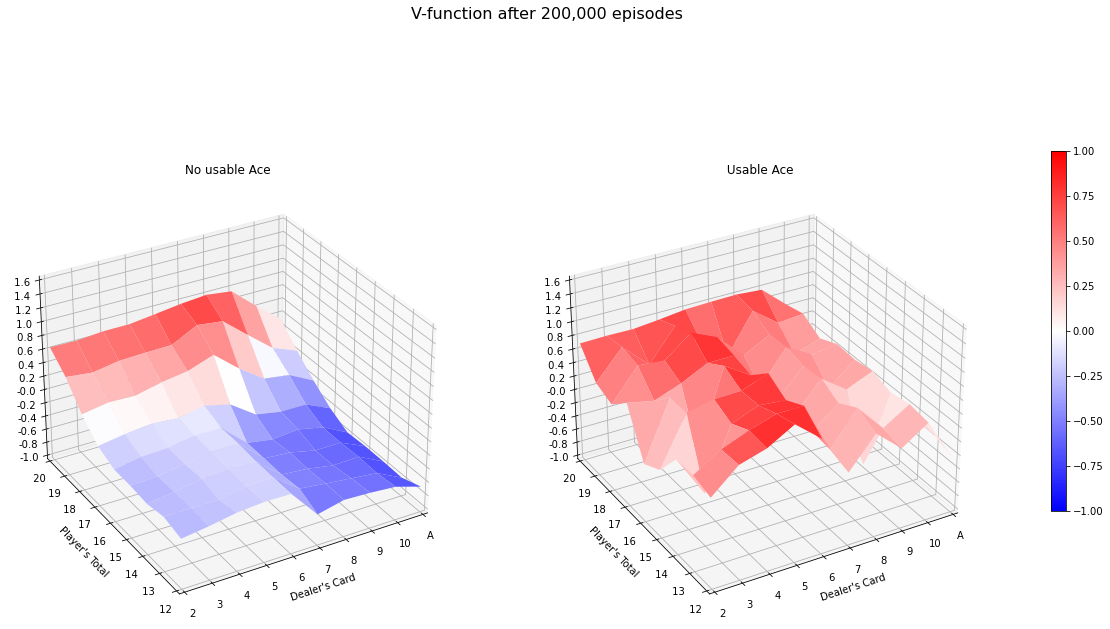

In [54]:
plot_v_func(np.amax(watkins.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

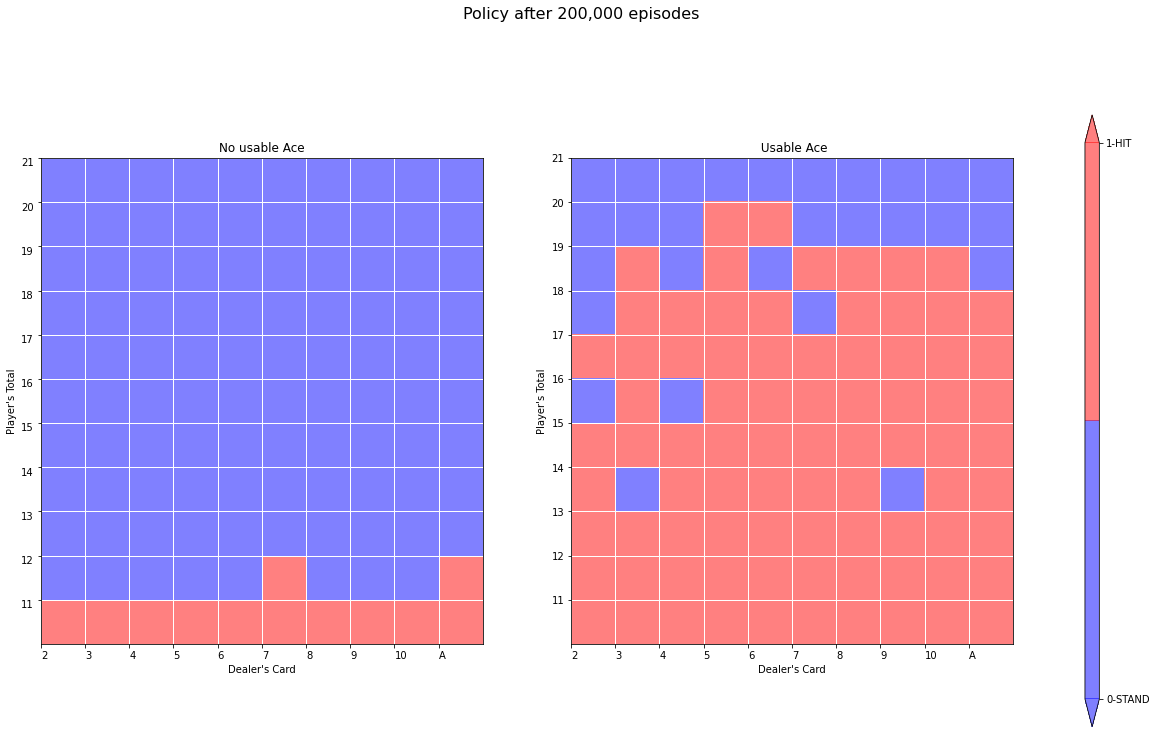

In [56]:
policy_table = np.argmax(watkins.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));